## Environment

In [ ]:
#show running-config
!nvidia-smi

Fri Nov  5 20:07:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    60W / 149W |   2305MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
###Setting environment

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import os
import random
import shutil

# To make this notebook's output stable across runs
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 1.Obtain data

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Google Colab provides downloadable links to data from Google drive.

#Downloading Chars74K Fnt dataset
id='1Y0yA4Es0chjdVVH1BBgKRGtAe6zDigyF'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('EnglishFnt.tgz')


#Downloading pre-trained model created by myself
id='13IbTayuBLUuoe_lT6bHcOVDPmMe3X7Xy'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('group98_pretrained_model.h5')

In [ ]:
!tar -xzvf "/content/EnglishFnt.tgz" -C "/content" 

流式输出内容被截断，只能显示最后 5000 行内容。
English/Fnt/Sample043/img043-00095.png
English/Fnt/Sample043/img043-00096.png
English/Fnt/Sample043/img043-00097.png
English/Fnt/Sample043/img043-00098.png
English/Fnt/Sample043/img043-00099.png
English/Fnt/Sample043/img043-00100.png
English/Fnt/Sample043/img043-00101.png
English/Fnt/Sample043/img043-00102.png
English/Fnt/Sample043/img043-00103.png
English/Fnt/Sample043/img043-00104.png
English/Fnt/Sample043/img043-00105.png
English/Fnt/Sample043/img043-00106.png
English/Fnt/Sample043/img043-00108.png
English/Fnt/Sample043/img043-00109.png
English/Fnt/Sample043/img043-00110.png
English/Fnt/Sample043/img043-00111.png
English/Fnt/Sample043/img043-00112.png
English/Fnt/Sample043/img043-00113.png
English/Fnt/Sample043/img043-00114.png
English/Fnt/Sample043/img043-00115.png
English/Fnt/Sample043/img043-00116.png
English/Fnt/Sample043/img043-00117.png
English/Fnt/Sample043/img043-00118.png
English/Fnt/Sample043/img043-00119.png
English/Fnt/Sample043/img043-00120.pn

## 2.Check sample

(128, 128, 3)

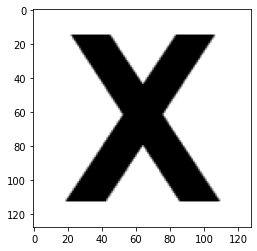

In [ ]:
import cv2
imgpath = '/content/English/Fnt/Sample034/img034-00138.png' #Show  a image  as  sample
img_sam= cv2.imread(imgpath)
plt.imshow(img_sam)
img_sam.shape

## 3.Split data

In [ ]:
def make_dir(source, target):
    dir_names = os.listdir(source)
    for names in dir_names:
        for i in ['train', 'valid', 'test']:
            path = target + '/' + i + '/' + names
            if not os.path.exists(path):
                os.makedirs(path)

In [ ]:
def divideTrainValiTest(source, target):
   
    # Gets the category under the source file
    pic_name = os.listdir(source)
    
    # Operates on  images in each category
    for classes in pic_name:
        # Gets the name of a certain type of image
        pic_classes_name = os.listdir(os.path.join(source, classes))
        random.shuffle(pic_classes_name)
        
        # divided in  8:1:1 
        train_list = pic_classes_name[0:int(0.8 * len(pic_classes_name))]
        valid_list = pic_classes_name[int(0.8 * len(pic_classes_name)):int(0.9 * len(pic_classes_name))]
        test_list = pic_classes_name[int(0.9 * len(pic_classes_name)):]
        
        # For each image, move into the corresponding folder
        for train_pic in train_list:
            shutil.copyfile(source + '/' + classes + '/' + train_pic, target + '/train/' + classes + '/' + train_pic)
        for validation_pic in valid_list:
            shutil.copyfile(source + '/' + classes + '/' + validation_pic,
                            target + '/valid/' + classes + '/' + validation_pic)
        for test_pic in test_list:
            shutil.copyfile(source + '/' + classes + '/' + test_pic, target + '/test/' + classes + '/' + test_pic)

In [ ]:
filepath = r'/content/English/Fnt'
dist = r'/content/English/NewFnt'
make_dir(filepath, dist)
divideTrainValiTest(filepath, dist)

## 4.Pre-process data

In [ ]:
#Image preprocessing
data_generator = ImageDataGenerator(rescale=1.0/255.0) #normalized

train_generator = data_generator.flow_from_directory( #Select the batch sizes extracted from the directory, rather than loading them all.
    '/content/English/NewFnt/train',
    target_size = (128, 128),#All graphs found will be adjusted to this dimension
    batch_size = 128, #The size of the  batch
    color_mode = 'grayscale', #The image is converted to one color channel
    class_mode = 'categorical', #Returns the type of the label array, 2D one-HOT encoded label
)

validation_generator = data_generator.flow_from_directory(
    '/content/English/NewFnt/valid',
    target_size = (128, 128),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical',
)

test_generator = data_generator.flow_from_directory(
    '/content/English/NewFnt/test',
    target_size = (128, 128),
    shuffle = False,
    color_mode='grayscale',
    class_mode = 'categorical',

)

Found 50344 images belonging to 62 classes.
Found 6324 images belonging to 62 classes.
Found 6324 images belonging to 62 classes.


In [ ]:
#view batch specifications
batch_train_x, batch_train_y = train_generator.next()
print('batch_train_x shape=%s, min=%.3f, max=%.3f' % (batch_train_x.shape, batch_train_x.min(), batch_train_x.max())) 
batch_validation_x, batch_validation_y = validation_generator.next()
print('batch_validation_x shape=%s, min=%.3f, max=%.3f' % (batch_validation_x.shape, batch_validation_x.min(), batch_validation_x.max()))

batch_train_x shape=(128, 128, 128, 1), min=0.000, max=1.000
batch_validation_x shape=(64, 128, 128, 1), min=0.000, max=1.000


In [ ]:
batch_train_y[0][:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## 5.Build the model and set hyperparameters

In [ ]:
#create the model, (single CONV layer between every POOL layer)
model = Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(4,4), strides = (1,1), input_shape = (128, 128, 1), activation = 'relu'))
model.add(layers.BatchNormalization(axis=-1)) #Axes to be normalized (usually characteristic axes)
model.add(layers.MaxPooling2D(pool_size = (4,4), strides = (2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(4,4), strides = (1,1), activation = 'relu'))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D(pool_size = (4,4),strides = (2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(310, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(62, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

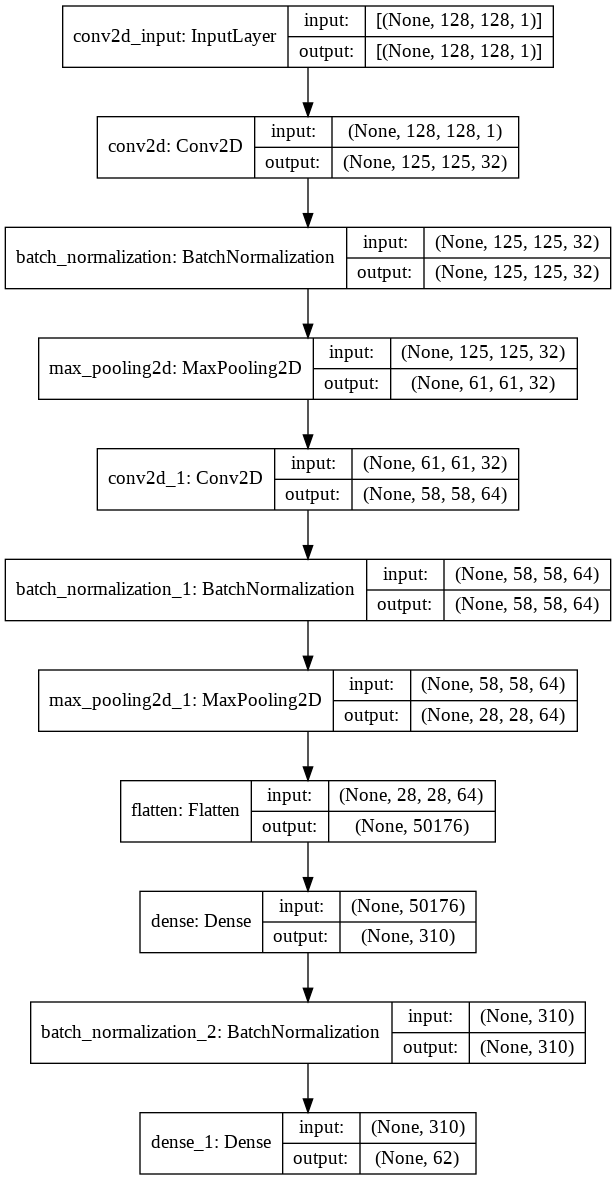

In [ ]:
keras.utils.plot_model(model, "Chars74K_Fnt_model.png", show_shapes=True)

## 6.Train the model and save pretrained model

In [ ]:
#fit model and save the best model
checkpoint = keras.callbacks.ModelCheckpoint("group98_pretrained_model.h5",
                        save_best_only = True,
                        monitor = 'val_categorical_accuracy',
                        verbose = 1)

history = model.fit(train_generator,
           steps_per_epoch = len(train_generator),
           epochs=10,
           validation_data=validation_generator,
           validation_steps = len(validation_generator),
           callbacks=[checkpoint],
           verbose = 1)

Epoch 1/10
394/394 [==============================] - 91s 151ms/step - loss: 0.6538 - categorical_accuracy: 0.8144 - val_loss: 6.3213 - val_categorical_accuracy: 0.0911

Epoch 00001: val_categorical_accuracy improved from -inf to 0.09108, saving model to group98_pretrained_model.h5
Epoch 2/10
394/394 [==============================] - 59s 149ms/step - loss: 0.2853 - categorical_accuracy: 0.8990 - val_loss: 0.4907 - val_categorical_accuracy: 0.8545

Epoch 00002: val_categorical_accuracy improved from 0.09108 to 0.85452, saving model to group98_pretrained_model.h5
Epoch 3/10
394/394 [==============================] - 59s 149ms/step - loss: 0.2082 - categorical_accuracy: 0.9240 - val_loss: 0.2902 - val_categorical_accuracy: 0.9031

Epoch 00003: val_categorical_accuracy improved from 0.85452 to 0.90307, saving model to group98_pretrained_model.h5
Epoch 4/10
394/394 [==============================] - 59s 148ms/step - loss: 0.1703 - categorical_accuracy: 0.9352 - val_loss: 0.2880 - val_categ

In [ ]:
# can use pretrained model (idenrical to 'history') for executing testing
pr_model = tf.keras.models.load_model('group98_pretrained_model.h5')

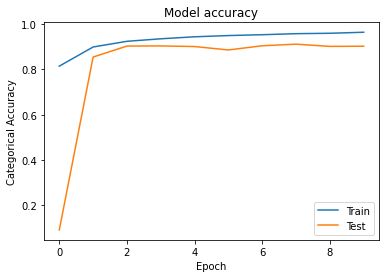

In [ ]:
#plot the fitting history
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

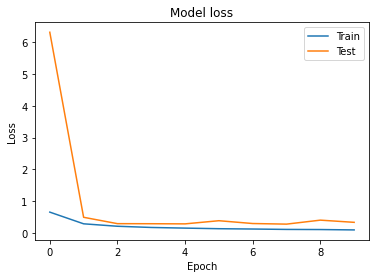

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## 7.Test the model on test data

In [ ]:
#evaluate the model
eval = pr_model.evaluate(test_generator, verbose=1)
print('pr_model performance:')
print('loss for test dataset is : {:.2f}'.format(eval[0]))
print('categorical_accuracy for test dataset is : {:.2f}'.format(eval[1]))

198/198 [==============================] - 5s 23ms/step - loss: 0.3192 - categorical_accuracy: 0.9086
pr_model performance:
loss for test dataset is : 0.32
categorical_accuracy for test dataset is : 0.91


## 8.Evaluate result

In [ ]:
import math
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [ ]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   Sample001       0.79      0.83      0.81       102
   Sample002       0.98      0.92      0.95       102
   Sample003       0.99      1.00      1.00       102
   Sample004       1.00      0.98      0.99       102
   Sample005       0.98      1.00      0.99       102
   Sample006       1.00      0.99      1.00       102
   Sample007       1.00      1.00      1.00       102
   Sample008       1.00      1.00      1.00       102
   Sample009       0.99      0.98      0.99       102
   Sample010       1.00      1.00      1.00       102
   Sample011       0.97      0.98      0.98       102
   Sample012       0.95      0.98      0.97       102
   Sample013       0.80      0.84      0.82       102
   Sample014       0.96      0.97      0.97       102
   Sample015       0.93      0.96      0.95       102
   Sample016       0.94      0.94      0.94       102
   Sample017       0.90      0.96      0.93       102
   Sample018       0.96    